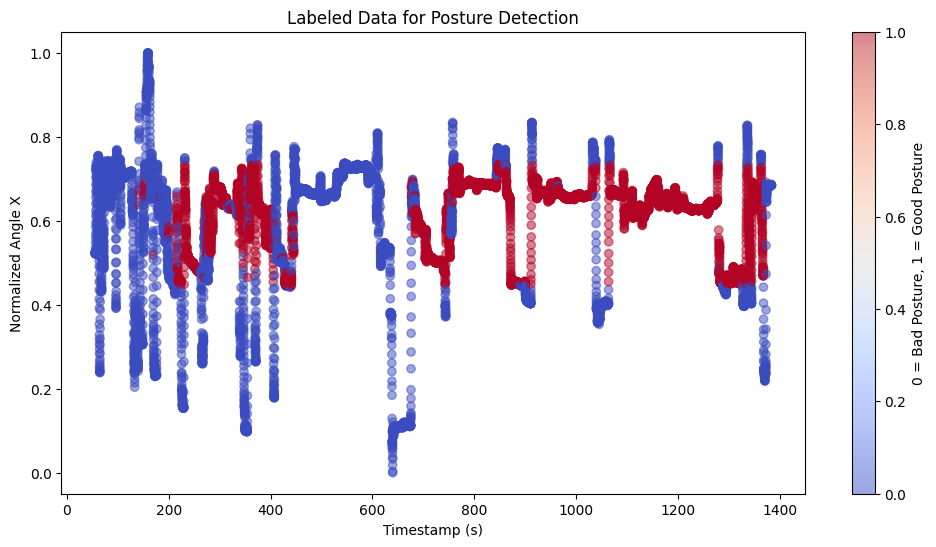

posture_label
1    11111
0     8079
Name: count, dtype: int64

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Define Good Posture Range using Mean ± Standard Deviation
angle_means = df[["angle_x", "angle_y", "angle_z"]].mean()
angle_stds = df[["angle_x", "angle_y", "angle_z"]].std()

thresholds = {
    "angle_x": (angle_means["angle_x"] - angle_stds["angle_x"], angle_means["angle_x"] + angle_stds["angle_x"]),
    "angle_y": (angle_means["angle_y"] - angle_stds["angle_y"], angle_means["angle_y"] + angle_stds["angle_y"]),
    "angle_z": (angle_means["angle_z"] - angle_stds["angle_z"], angle_means["angle_z"] + angle_stds["angle_z"]),
}

# Step 2: Label Data (1 = Good Posture, 0 = Bad Posture)
df["posture_label"] = ((df["angle_x"].between(*thresholds["angle_x"])) &
                        (df["angle_y"].between(*thresholds["angle_y"])) &
                        (df["angle_z"].between(*thresholds["angle_z"]))).astype(int)

# Step 3: Normalize Data
scaler = MinMaxScaler()
df[["angle_x", "angle_y", "angle_z"]] = scaler.fit_transform(df[["angle_x", "angle_y", "angle_z"]])

# Step 4: Visualize Labeled Data
plt.figure(figsize=(12, 6))
plt.scatter(df["timestamp"], df["angle_x"], c=df["posture_label"], cmap="coolwarm", label="Posture Label", alpha=0.5)
plt.xlabel("Timestamp (s)")
plt.ylabel("Normalized Angle X")
plt.title("Labeled Data for Posture Detection")
plt.colorbar(label="0 = Bad Posture, 1 = Good Posture")
plt.show()

# Count of good vs. bad postures
df["posture_label"].value_counts()


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

# Define sequence length for LSTM input
sequence_length = 50  # 50 time steps per sequence

# Extract input features and target labels
features = df[["angle_x", "angle_y", "angle_z"]].values
labels = df["posture_label"].values

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)

# Create LSTM sequences using TimeseriesGenerator
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=32)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=32)

# Print shape of generated sequences
len(train_generator), len(test_generator)


(479, 119)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification (good/bad posture)
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Get input shape from the data
input_shape = (sequence_length, 3)  # (timesteps, features)
model = create_lstm_model(input_shape)

# Train the model
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("lstm_posture_model.h5")


Epoch 1/20


C:\Users\Shivam Singh\OneDrive\Desktop\ML\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  8/479 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9559 - loss: 0.6041

C:\Users\Shivam Singh\OneDrive\Desktop\ML\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


479/479 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5821 - loss: 0.6839 - val_accuracy: 0.8780 - val_loss: 0.5785
Epoch 2/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6558 - loss: 0.6359 - val_accuracy: 0.8603 - val_loss: 0.6245
Epoch 3/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5316 - loss: 0.6926 - val_accuracy: 0.8603 - val_loss: 0.5206
Epoch 4/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5315 - loss: 0.6804 - val_accuracy: 0.8603 - val_loss: 0.6719
Epoch 5/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5056 - loss: 0.6942 - val_accuracy: 0.8603 - val_loss: 0.6778
Epoch 6/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4913 - loss: 0.6947 - val_accuracy: 0.8603 - val_loss: 0.6840
Epoch 7/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4935 - loss: 0.6942 - val_accuracy: 0.8603 - val_loss: 0.6864
Epoch 8/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4819 - loss: 0.6941 - val_accuracy: 0.86

Test Accuracy: 86.03%
